In [25]:
import sys
from truth_ssd import SSD
import os
import torch

voc_classes = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

ssd_cfg = {
    'classes_num': 21,
    'input_size': 300,
    'dbox_num': [4, 6, 6, 6, 4, 4],
    'feature_maps': [38, 19, 10, 5, 3, 1],
    'steps': [8, 16, 32, 64, 100, 300],
    'min_sizes': [30, 60, 111, 162, 213, 264],
    'max_sizes': [60, 111, 162, 213, 264, 315],
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

net = SSD(phase='test', cfg=ssd_cfg)
weight_pth = './weights/ssd_weights_0/ssd_weights_200.pth'
net_weights = torch.load(weight_pth, map_location={'cuda:0': 'cpu'})
net.load_state_dict(net_weights)
print('Preparation is finished!')

Preparation is finished!


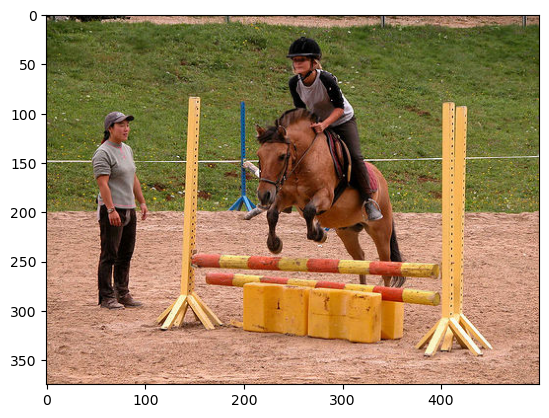

torch.Size([1, 21, 200, 5])
tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0363,  0.9383,  0.0128,  0.9966,  0.0598],
          [ 0.0290,  0.2852,  0.2239,  0.3211,  0.2633],
          [ 0.0285,  0.1498,  0.2747,  0.1862,  0.3074],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.1661,  0.1100,  0.3852,  0.2377,  0.8185],
          [ 0.1397,  0.4019,  0.3128,  0.7442,  0.7886],
          [ 0.0897,  0.5408,  0.4828,  0.6904,  0.7914],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [

c:\Users\ShimaSef\object_detection\truth_ssd.py:530: UserWarning: An output with one or more elements was resized since it had shape [89], which does not match the required output shape [86]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Resize.cpp:33.)
  torch.index_select(x1, 0, idx, out=tmp_x1) # 昇順スコアに対応するxminの並び
c:\Users\ShimaSef\object_detection\truth_ssd.py:531: UserWarning: An output with one or more elements was resized since it had shape [89], which does not match the required output shape [86]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered

In [26]:
import cv2
from truth_voc import DataTransform
import matplotlib.pyplot as plt
%matplotlib inline

image_file_path = './data/VOCdevkit/VOC2012/JPEGImages/2012_004198.jpg'
# image_file_path = './data/group_photo.jpg'
img = cv2.imread(image_file_path)
height, width, channels = img.shape
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
color_mean = (104, 117, 123)
input_size = 300
transform = DataTransform(input_size, color_mean)

phase = 'val'
img_transformed, boxes, labels = transform(
  img,
  phase,
  '',
  ''
)
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

net.eval()
x = img.unsqueeze(0)
detections = net(x)
print(detections.shape)
print(detections)

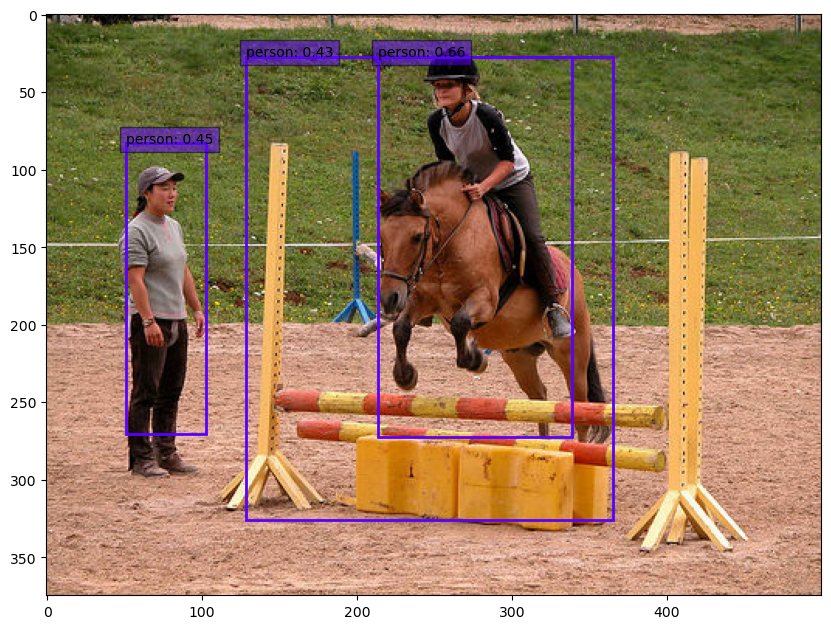

In [27]:
import sys
from truth_ssd_predictions import SSDPredictions

# image_file_path = './data/road_tokyo.jpg'
ssd = SSDPredictions(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, confidence_threshold=0.3)